In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/VNAV/

## Imports

In [43]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from PIL import Image
import natsort
from collections import Counter

from gardens import * # custom dataset class


## Read in and set up dataset

In [ ]:
gardens_obj = Gardens(datasets_folder='./',
             dataset_name="gardens",
             split="train",
             use_ang_positives=False,
             dist_thresh = 10,
             ang_thresh=20,
             use_mixVPR=False,
             use_SAM=False
            )

In [40]:
save_dir = "./cache/siftbow"
k_clusters=100 # number of clusters


## Create codebook/vocabulary
Only run if never done before/cache not populated

In [32]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        # category = []
        path = folder + "/" + filename
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # print(img.shape)
        # for cat in os.listdir(path):
        #     img = cv2.imread(path + "/" + cat,0)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # if img is not None:
            #     category.append(img)
        images.append(img)
    return images

def extract_sift_features(img_folder):
    """
    Given path to folder of images to process, extracts OpenCV SIFT 
    descriptors and returns them as an unorded list
    """
    images = load_images_from_folder(img_folder)
    descriptor_list = []
    sift = cv2.SIFT_create()

    for img in tqdm(images):
        kp, des = sift.detectAndCompute(img,None)
        descriptor_list.extend(des)

    return descriptor_list

# unordered descriptor list and sift features for reference data
descriptor_list = extract_sift_features('./gardens/day_left')
len(descriptor_list)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
def run_kmeans(k, descriptor_list):
    """
    Given number of desired clusters k and list of descriptors (output of 
    extract_sift_features()), fits the data via k-means clustering and 
    returns array of the cluster centers
    """
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_
    return visual_words

visual_words = run_kmeans(k_clusters, descriptor_list)

In [ ]:
np.save(f"{save_dir}/kmeans_{k_clusters}_sift.npy", visual_words) # this is the vocabulary for the dataset

## Descriptor generation

Save into cache

In [44]:
# set up kmeans object using cached cluster centers
cached_cluster_centers = np.load(f"{save_dir}/kmeans_{k_clusters}_sift.npy")
kmeans = KMeans(n_clusters = k_clusters, init=cached_cluster_centers, n_init=1)
kmeans.fit(cached_cluster_centers)

# helper definitions
sift = cv2.SIFT_create()
get_freq = lambda i: pred_counter[i] if i in pred_counter else 0


# compute descriptors for the datasets
datasets = [gardens_obj.db_abs_paths, gardens_obj.q_abs_paths_day_left, gardens_obj.q_abs_paths_night_right]

for img_fnames in datasets:
    img_fnames = natsort.natsorted(img_fnames)
    frame = img_fnames[0].replace("\\", "/").split("/")[-2] # this is either "day_right", "day_left", or "night_right" depending on which subset of dataset is being processed

    for img_fname in tqdm(img_fnames):
        # SIFT features
        img = cv2.cvtColor(cv2.imread(img_fname), cv2.COLOR_BGR2GRAY)
        _, des = sift.detectAndCompute(img,None)
        des = np.array(des, dtype=float) # cast to float for compatibility with sklearn's kmeans.predict

        # BOW global descriptor
        pred = kmeans.predict(des)
        pred_counter = Counter(pred)
        hist = np.array([get_freq(i) for i in range(k_clusters)])
        
        np.save(f"{save_dir}/descriptors/{frame}/{os.path.basename(img_fname)}.npy", hist)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Perform Evaluations: Recall@K
Recall done via plain sklearn KNN. Reads cached descriptors into memory and then run evaluations

In [6]:
descriptors_dir = "./cache/siftbow/descriptors"
# descriptors_dir = "./cache/anyloc/descriptors_urban"

splits = ["day_right", "day_left", "night_right"]

loaded_descriptors = [[], [], []]
for i in range(len(splits)):
  print("loading", splits[i])
  files = os.listdir(os.path.join(descriptors_dir, splits[i]))
  for img_fname in tqdm(files):
      desc = np.load(f"{os.path.join(descriptors_dir, splits[i], img_fname)}")
      loaded_descriptors[i].append(desc)

database, night_right_queries, day_left_queries = loaded_descriptors


loading day_right


  0%|          | 0/200 [00:00<?, ?it/s]

loading day_left


  0%|          | 0/200 [00:00<?, ?it/s]

loading night_right


  0%|          | 0/200 [00:00<?, ?it/s]

In [45]:
# evaluate all of night_right and day_left queries
nearest_k = 5 # set this
neigh = NearestNeighbors(n_neighbors=nearest_k)
neigh.fit(database)
print(f"Using k={nearest_k}")

gt_pos = gardens_obj.soft_positives_per_query #[query_index]

day_left_matches = 0
for i in tqdm(range(len(day_left_queries))):
  dists, indices = neigh.kneighbors(day_left_queries[i:i+1], n_neighbors=nearest_k, return_distance=True)

  if len(np.intersect1d(indices, gt_pos[i])) > 0:
      day_left_matches += 1
print(f"day_left_matches: {day_left_matches} of {len(day_left_queries)}, match rate: {day_left_matches/len(day_left_queries)}")


night_right_matches = 0
for i in tqdm(range(len(night_right_queries))):
  dists, indices = neigh.kneighbors(night_right_queries[i:i+1], n_neighbors=nearest_k, return_distance=True)

  if len(np.intersect1d(indices, gt_pos[i])) > 0:
      night_right_matches += 1
print(f"night_right_matches: {night_right_matches} of {len(night_right_queries)}, match rate: {night_right_matches/len(night_right_queries)}")



Using k=5


  0%|          | 0/200 [00:00<?, ?it/s]

day_left_matches: 38 of 200, match rate: 0.19


  0%|          | 0/200 [00:00<?, ?it/s]

night_right_matches: 178 of 200, match rate: 0.89


query result: {27: 64.52906321960671, 28: 66.73080248281148, 29: 67.97058187186572, 24: 68.16890786861705, 25: 69.24593850905626}
valid positives (ground truth): [23, 24, 25, 26, 27]
match found at index 27
night query, index 25


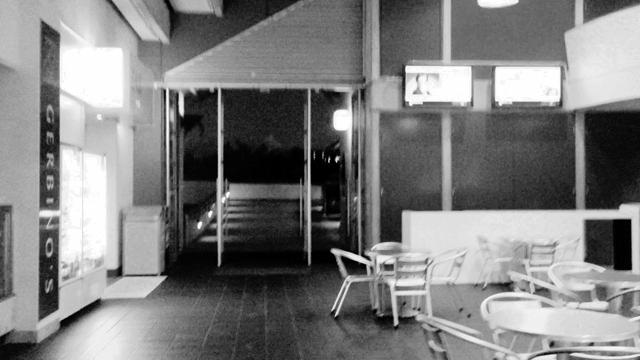

best retreival (day right), index 27


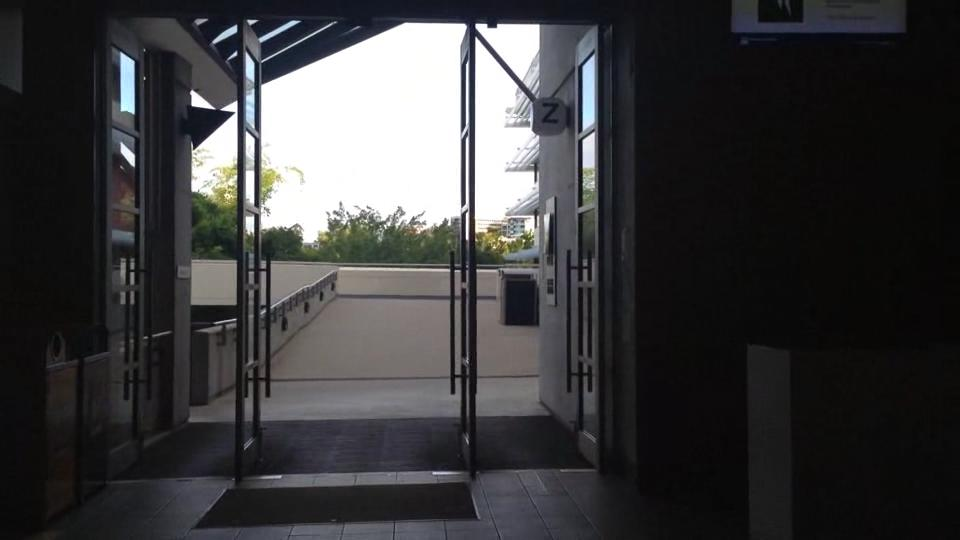

In [30]:
# Use this cell to inspect individual queries:
def check_retreival_match(qu_result, valid_positives):
  for ind in qu_result:
    if (ind in valid_positives):
      print("match found at index", ind)
      return ind, qu_result[ind] # return index and similarity
  print("returning closest match by distance")
  return list(qu_result)[0], list(qu_result.values())[0]
#   return -1, None

nearest_k = 5
query_index = 25 # range: [0, 199]

## toggle which test set to query
qu = night_right_queries[query_index:query_index+1]
# qu = day_left_queries[query_index:query_index+1]

gt_pos = gardens_obj.soft_positives_per_query #[query_index]

## search for nearest neighbors
distances, indices = neigh.kneighbors(qu, n_neighbors=nearest_k, return_distance=True)
qu_result = {indices[0][i]:distances[0][i] for i in range(nearest_k)}
print("query result:", qu_result)
# key: index of match in ref database (full_db)
# value: cossim between query qu to retreival full_db[key]
# in order from most to least similar

print("valid positives (ground truth):", gt_pos[query_index])

best_match_ind, min_dist = check_retreival_match(qu_result, gt_pos[query_index])

## Visualize query vs retrival
# print("day left query, index", query_index)
# display(gardens_obj.show_day_left_item(query_index))

print("night query, index", query_index)
display(gardens_obj.show_night_right_item(query_index))

print("best retreival (day right), index", best_match_ind)
display(gardens_obj.show_day_right_item(best_match_ind))